### 1.1 Descripción del Problema de clasificación.

El dataset de clasificación es el de entrenamiento (train.csv) de la competición de Kaggle (https://www.kaggle.com/competitions/titanic) en la que se propone predecir la columna Survived (que determina si un pasajero del Titanic sobrevivió o no al accidente de este transatlántico) basándose en un set de prueba (test.csv) de la competición para subir las predicciones a Kaggle y ver el accuracy del modelo entrenado en este set de prueba.  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('titanic.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Como la columna PassangerId no es relevante para el análisis, la eliminamos.

In [4]:
df = df.drop('PassengerId', axis = 1)

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.shape

(891, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


Vamos a pasar la columna Survived a str para que nos sirva el resumen de la función describe.

In [7]:
df['Survived'] = df['Survived'].astype(str)

In [8]:
df.describe(include = [np.number])

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
df.describe(include = [object])

,Survived,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,204,889
unique,2,891,2,681,147,3
top,0,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,549,1,577,7,4,644


Volvemos a pasar Survived a int para poder entrenar la regresión logística.

In [10]:
df['Survived'] = df['Survived'].astype(int)

In [11]:
df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

### 2.1 Análisis Exploratorio de Datos (EDA) del problema de clasificación.

In [12]:
df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].skew()

Survived    0.478523
Pclass     -0.630548
Age         0.389108
SibSp       3.695352
Parch       2.749117
Fare        4.787317
dtype: float64

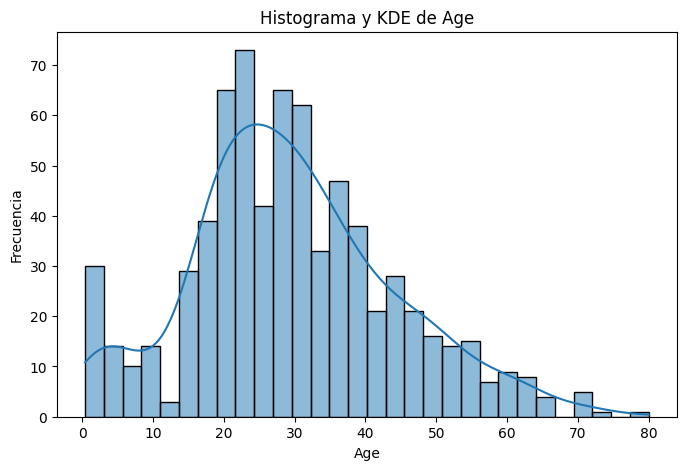

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df['Age'].dropna(), kde=True, bins=30)
plt.title('Histograma y KDE de Age')
plt.xlabel('Age')
plt.ylabel('Frecuencia')
plt.show()

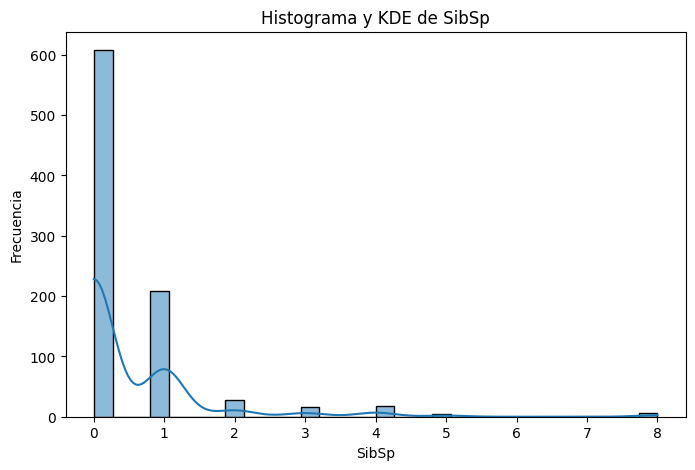

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df['SibSp'].dropna(), kde=True, bins=30)
plt.title('Histograma y KDE de SibSp')
plt.xlabel('SibSp')
plt.ylabel('Frecuencia')
plt.show()

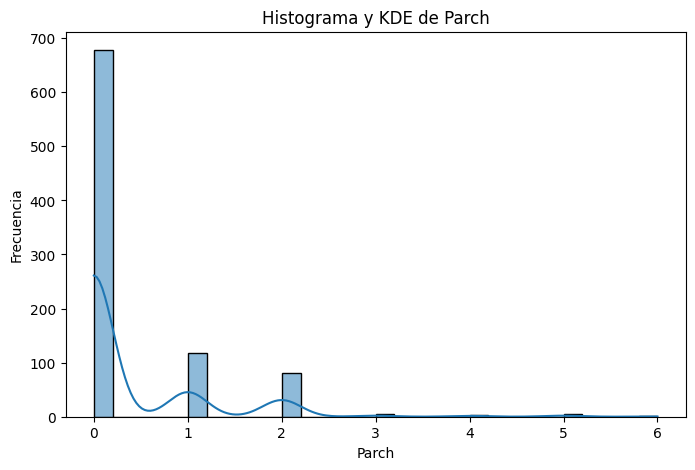

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(df['Parch'].dropna(), kde=True, bins=30)
plt.title('Histograma y KDE de Parch')
plt.xlabel('Parch')
plt.ylabel('Frecuencia')
plt.show()

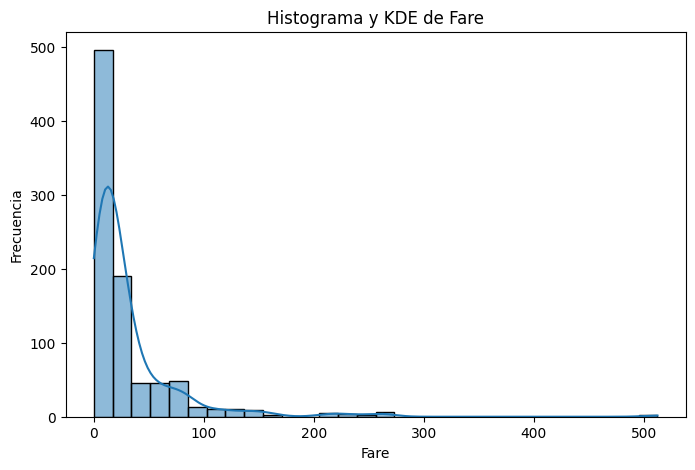

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(df['Fare'].dropna(), kde=True, bins=30)
plt.title('Histograma y KDE de Fare')
plt.xlabel('Fare')
plt.ylabel('Frecuencia')
plt.show()

Text(0.5, 1.0, 'Matriz de Correlación')

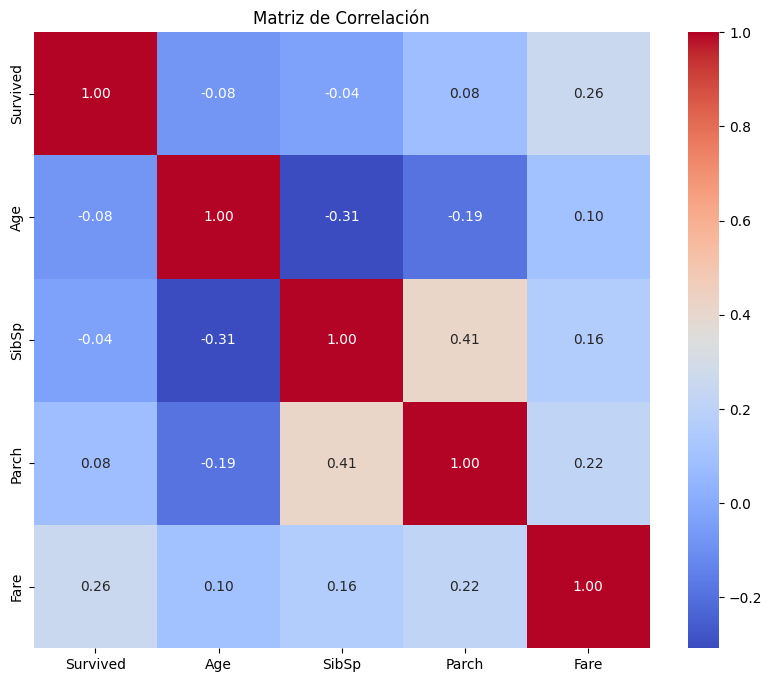

In [17]:
matriz_de_correlacion = df[['Survived','Age', 'SibSp', 'Parch', 'Fare']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_de_correlacion, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')


In [18]:
def crosstabs(df, col1, col2):

    total_filas = len(df)

    valores_no_nulos = df[col2].notna().sum()

    crosstab_index = pd.crosstab(df[col1], df[col2], normalize='index') * 100
    crosstab_index = crosstab_index.round(2)

    crosstab_all = pd.crosstab(df[col1], df[col2], normalize='all') * 100
    crosstab_all = crosstab_all.round(2)

    crosstab_columns = pd.crosstab(df[col1], df[col2], normalize='columns') * 100
    crosstab_columns = crosstab_columns.round(2)

    # El siguiente código es para poder ver las tablas sin tener que scrollear horizontal ni verticalmente en VSC.

    html = f"""
    <div style="display: flex; flex-wrap: wrap; gap: 30px;">
        <div>
            <b>Cantidad total de filas del DataFrame:</b> {total_filas}<br>
            <b>Cantidad de valores no nulos en '{col2}':</b> {valores_no_nulos}
        </div>
        <div>
            <b>Crosstab por índice:</b>
            {crosstab_index.to_html()}
        </div>
        <div>
            <b>Crosstab por total:</b>
            {crosstab_all.to_html()}
        </div>
        <div>
            <b>Crosstab por columnas:</b>
            {crosstab_columns.to_html()}
        </div>
    </div>
    """
    display(HTML(html))

In [19]:
crosstabs(df, 'Survived', 'Pclass')

Pclass,1,2,3
Survived,,,
0,14.57,17.67,67.76
1,39.77,25.44,34.80
Pclass,1,2,3
Survived,,,
0,8.98,10.89,41.75
1,15.26,9.76,13.36
Pclass,1,2,3
Survived,,,
0,37.04,52.72,75.76


Notamos que de los pasajeros que murieron el 67,76% eran de clase baja, el 
41,75% de los pasajeros del dataset eran de clase baja y murieron, y que el 
75,76% de los pasajeros de clase baja no sobrevivieron, esto nos hace pensar que hay una relación entre la variable Survived y la variable Pclass.

In [20]:
crosstabs(df, 'Survived', 'Sex')

Sex,female,male
Survived,,
0,14.75,85.25
1,68.13,31.87
Sex,female,male
Survived,,
0,9.09,52.53
1,26.15,12.23
Sex,female,male
Survived,,
0,25.8,81.11


Notamos que el 85,25% de los no sobrevivientes fueron hombres, y el 68,13% de los pasajeros sobrevivientes fueron mujeres. Además el 52,53% de los pasajeros del Titanic fueron hombres que no sobrevivieron, el 74,2% de las mujeres pasajeras del titanic sobrevivieron y el 81,11% de los pasajeros hombres no sobrevivieron. Todo lo anterior claramente indica una relación entre la variable Sex y la variable Survived.

In [21]:
crosstabs(df, 'SibSp', 'Survived')

Survived,0,1
SibSp,,
0,65.46,34.54
1,46.41,53.59
2,53.57,46.43
3,75.00,25.00
4,83.33,16.67
5,100.00,0.00
8,100.00,0.00
Survived,0,1
SibSp,,


No parece haber un relación fuerte entre la variable SibSp y la variable Survived. No obstante, como la consigna de TP dice que debemos entrenar un modelo con todas las variables independientes y luego con las elegidas por un método de selección o importancia de características, la dejamos en el dataset.

In [22]:
crosstabs(df, 'Survived', 'Parch')

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,81.06,9.65,7.29,0.36,0.73,0.73,0.18
1,68.13,19.01,11.70,0.88,0.00,0.29,0.00
Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,49.94,5.95,4.49,0.22,0.45,0.45,0.11
1,26.15,7.30,4.49,0.34,0.00,0.11,0.00
Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,65.63,44.92,50.0,40.0,100.0,80.0,100.0


In [23]:
crosstabs(df, 'Survived', 'Embarked')

Embarked,C,Q,S
Survived,,,
0,13.66,8.56,77.78
1,27.35,8.82,63.82
Embarked,C,Q,S
Survived,,,
0,8.44,5.29,48.03
1,10.46,3.37,24.41
Embarked,C,Q,S
Survived,,,
0,44.64,61.04,66.3


Vemos que el 66% de los pasajeros que se embarcaron en el puerto de Southampton no sobrevivieron. También notamos que un 72,44% (48,03 + 24,41) de los pasajeros se embarcaron en Southampton (ver "Crosstab por total" de la celda de arriba). Así que completamos la columna Embarked con su moda.

In [24]:
df['Embarked'] = df['Embarked'].fillna('S')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int32  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 73.2+ KB


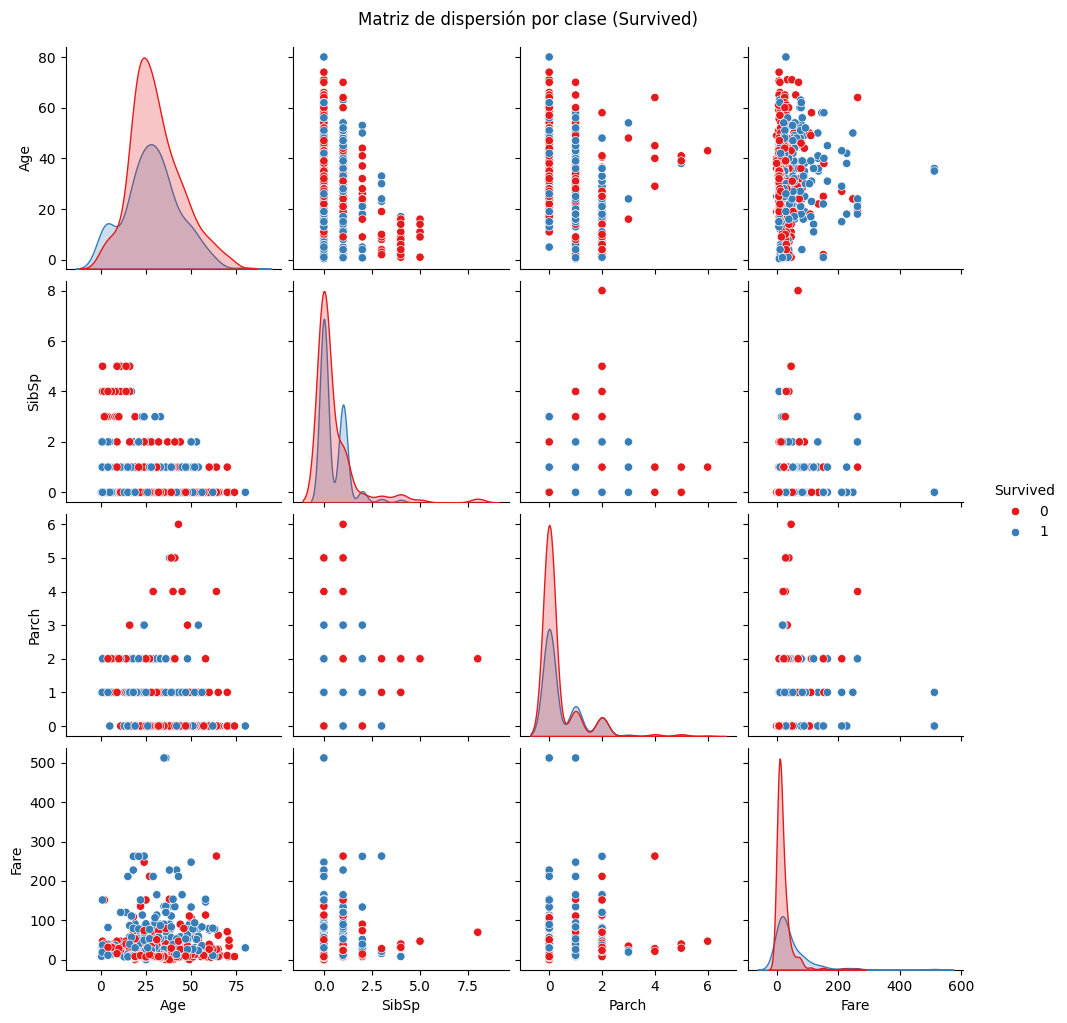

In [25]:
variables = ['Age', 'SibSp', 'Parch', 'Fare']

sns.pairplot(df[variables + ['Survived']], hue='Survived', palette='Set1', diag_kind='kde')
plt.suptitle('Matriz de dispersión por clase (Survived)', y=1.02)
plt.show()

In [26]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int32  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 73.2+ KB


Basándonos en los valores de la columna 'Name' podemos extraer el título (por ejemplo lo que en español sería Sr., Sra., Srta., etc.)

In [27]:
df['Titulo'] = df.Name.str.extract(r'([A-Za-z]+)\.', expand=False)

crosstabs(df, 'Survived', 'Titulo')

Titulo,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0,0.18,0.18,0.00,0.18,0.73,0.18,0.00,0.18,3.10,10.02,0.00,0.00,79.42,4.74,0.00,1.09,0.00
1,0.00,0.29,0.29,0.00,0.88,0.00,0.29,0.29,6.73,37.13,0.58,0.29,23.68,28.95,0.29,0.00,0.29
Titulo,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0,0.11,0.11,0.00,0.11,0.45,0.11,0.00,0.11,1.91,6.17,0.00,0.00,48.93,2.92,0.00,0.67,0.00
1,0.00,0.11,0.11,0.00,0.34,0.00,0.11,0.11,2.58,14.25,0.22,0.11,9.09,11.11,0.11,0.00,0.11
Titulo,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0,100.0,50.0,0.0,100.0,57.14,100.0,0.0,50.0,42.5,30.22,0.0,0.0,84.33,20.8,0.0,100.0,0.0


Podemos convertir los títulos poco frecuentes en la categoría "Otros". También podemos reemplazar términos que son un sinónimo de otro para reducir la cantidad de categorías.

In [28]:
df['Titulo'] = df['Titulo'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Otros')

df['Titulo'] = df['Titulo'].replace('Mlle', 'Miss')
df['Titulo'] = df['Titulo'].replace('Ms', 'Miss')
df['Titulo'] = df['Titulo'].replace('Mme', 'Mrs')

crosstabs(df, 'Survived', 'Titulo')

Titulo,Master,Miss,Mr,Mrs,Otros
Survived,,,,,
0,3.10,10.02,79.42,4.74,2.73
1,6.73,38.01,23.68,29.24,2.34
Titulo,Master,Miss,Mr,Mrs,Otros
Survived,,,,,
0,1.91,6.17,48.93,2.92,1.68
1,2.58,14.59,9.09,11.22,0.90
Titulo,Master,Miss,Mr,Mrs,Otros
Survived,,,,,
0,42.5,29.73,84.33,20.63,65.22


Ahora vamos a eliminar la columna "Name" y hacer one hot encoding con "Titulo".

Text(0.5, 0.98, '')

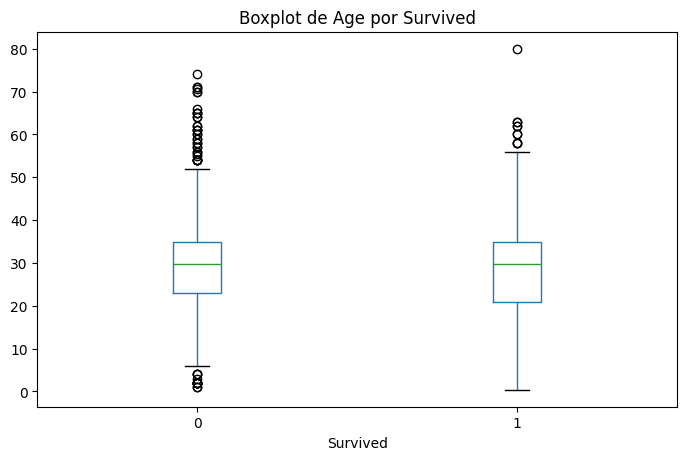

In [29]:
df.boxplot(column='Age', by='Survived', grid=False, figsize=(8, 5))
plt.title('Boxplot de Age por Survived')
plt.suptitle('')

Text(0.5, 0.98, '')

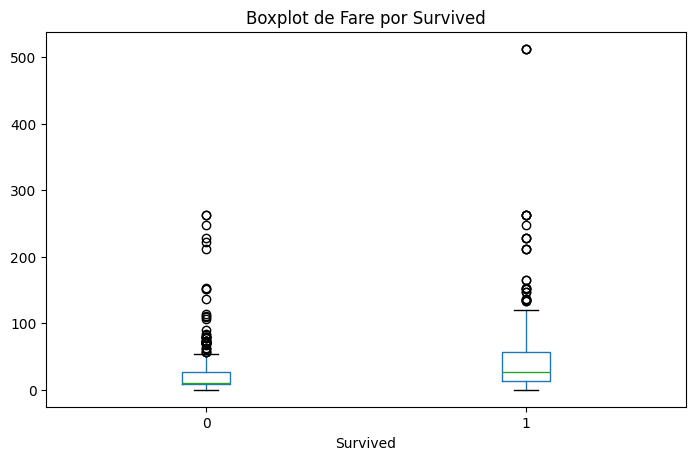

In [30]:
df.boxplot(column='Fare', by='Survived', grid=False, figsize=(8, 5))
plt.title('Boxplot de Fare por Survived')
plt.suptitle('')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int32  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
 11  Titulo    891 non-null    object 
dtypes: float64(2), int32(1), int64(3), object(6)
memory usage: 80.2+ KB


Vamos a cambiar los valores nulos de la columna Age por el promedio de los datos de esa columna que sí tenemos.

In [32]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int32  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
 11  Titulo    891 non-null    object 
dtypes: float64(2), int32(1), int64(3), object(6)
memory usage: 80.2+ KB


In [33]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [34]:
df.groupby('Cabin').size().sort_values(ascending=False)

Cabin
C23 C25 C27    4
G6             4
B96 B98        4
F2             3
C22 C26        3
              ..
C101           1
B94            1
B86            1
B82 B84        1
T              1
Length: 147, dtype: int64

Vemos que en las cabinas con más pasejeros había 4 pasajeros, y en las con menos pasajeros había solo un pasajero.

In [35]:
cabin_value_counts = df['Cabin'].value_counts()
cabin_cant_reps = cabin_value_counts.value_counts().sort_index(ascending=False)

print(f"La cantidad de veces que se repite cada cantidad de veces que se repite cada valor de Cabin es: {cabin_cant_reps}")

La cantidad de veces que se repite cada cantidad de veces que se repite cada valor de Cabin es: count
4      3
3      5
2     38
1    101
Name: count, dtype: int64


La mayoría de los pasajeros del dataset estaban solos en sus cabinas. Veamos si hay una relación entre el ticket y la cabina.

In [36]:
df_ticket_no_nan = df[df["Cabin"].notna()]

ticket_value_counts = df_ticket_no_nan['Ticket'].value_counts()
ticket_cant_reps = ticket_value_counts.value_counts().sort_index(ascending=False)

print(f"La cantidad de veces que se repite cada cantidad de veces que se repite cada valor de Ticket es: {ticket_cant_reps}")

La cantidad de veces que se repite cada cantidad de veces que se repite cada valor de Ticket es: count
4     2
3    10
2    36
1    94
Name: count, dtype: int64


Como hay menos repeticiones de solo una vez en ticket_cant_reps que en cabin_cant_reps eso significa que hubo pasajeros con el mismo ticket que fueron a diferentes cabinas. Podemos imputar los Nan´s en la columna Cabin y usar la función crosstabs dividiendo por Nan's y no Nan's.

In [37]:
df['Cabin'] = df['Cabin'].fillna('U')

df['Cabin_is_U'] = df['Cabin'] == 'U'

crosstabs(df, 'Survived', 'Cabin_is_U')

Cabin_is_U,False,True
Survived,,
0,12.39,87.61
1,39.77,60.23
Cabin_is_U,False,True
Survived,,
0,7.63,53.98
1,15.26,23.12
Cabin_is_U,False,True
Survived,,
0,33.33,70.01


Procesemos la columna Cabin_is_U con One-Hot Encoding y eliminemos la columna Cabin.

In [38]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo,Cabin_is_U
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,True
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,False
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,True
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,False
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,True


In [39]:
def eliminar_letras(texto):
  return ''.join([c for c in texto if not c.isalpha()])

df['TicketNumbers'] = df['Ticket'].apply(eliminar_letras)

print(f"Hay {len(df.groupby('TicketNumbers').size())} números diferentes en la columna TickerNumbers")

Hay 681 números diferentes en la columna TickerNumbers


Vemos que no hay números repetidos en la columna TicketNumbers, así que eliminamos esa columna.

In [40]:
df = df.drop("TicketNumbers", axis=1)

In [41]:
def eliminar_numeros(texto):
  return ''.join([c for c in texto if not c.isdigit()]) 

df['TicketLetters'] = df['Ticket'].apply(eliminar_numeros)

print(f"Hay {len(df.groupby("TicketLetters").size())} valores diferentes en la columna TicketLetters")

Hay 43 valores diferentes en la columna TicketLetters


In [42]:
df['Ticket_have_letters'] = df['TicketLetters'] != ''

crosstabs(df, 'Survived', 'Ticket_have_letters')

df = df.drop("TicketLetters", axis=1)

df = df.drop("Ticket", axis=1)

Ticket_have_letters,False,True
Survived,,
0,74.13,25.87
1,74.27,25.73
Ticket_have_letters,False,True
Survived,,
0,45.68,15.94
1,28.51,9.88
Ticket_have_letters,False,True
Survived,,
0,61.57,61.74


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Survived             891 non-null    int32  
 1   Pclass               891 non-null    int64  
 2   Name                 891 non-null    object 
 3   Sex                  891 non-null    object 
 4   Age                  891 non-null    float64
 5   SibSp                891 non-null    int64  
 6   Parch                891 non-null    int64  
 7   Fare                 891 non-null    float64
 8   Cabin                891 non-null    object 
 9   Embarked             891 non-null    object 
 10  Titulo               891 non-null    object 
 11  Cabin_is_U           891 non-null    bool   
 12  Ticket_have_letters  891 non-null    bool   
dtypes: bool(2), float64(2), int32(1), int64(3), object(5)
memory usage: 75.0+ KB


In [44]:
df.drop(["Name", "Cabin"], axis=1, inplace=True)

### 3.1 Preprocesamiento de Datos del problema de clasificación.

In [45]:
array = df.values

np.set_printoptions(threshold=np.inf)

X = array[:, 1:]
y = array[:, 0]

print(X)
print(y)

test_size = 0.33  
seed = 7

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

[[3 'male' 22.0 1 0 7.25 'S' 'Mr' True True]
 [1 'female' 38.0 1 0 71.2833 'C' 'Mrs' False True]
 [3 'female' 26.0 0 0 7.925 'S' 'Miss' True True]
 [1 'female' 35.0 1 0 53.1 'S' 'Mrs' False False]
 [3 'male' 35.0 0 0 8.05 'S' 'Mr' True False]
 [3 'male' 29.69911764705882 0 0 8.4583 'Q' 'Mr' True False]
 [1 'male' 54.0 0 0 51.8625 'S' 'Mr' False False]
 [3 'male' 2.0 3 1 21.075 'S' 'Master' True False]
 [3 'female' 27.0 0 2 11.1333 'S' 'Mrs' True False]
 [2 'female' 14.0 1 0 30.0708 'C' 'Mrs' True False]
 [3 'female' 4.0 1 1 16.7 'S' 'Miss' False True]
 [1 'female' 58.0 0 0 26.55 'S' 'Miss' False False]
 [3 'male' 20.0 0 0 8.05 'S' 'Mr' True True]
 [3 'male' 39.0 1 5 31.275 'S' 'Mr' True False]
 [3 'female' 14.0 0 0 7.8542 'S' 'Miss' True False]
 [2 'female' 55.0 0 0 16.0 'S' 'Mrs' True False]
 [3 'male' 2.0 4 1 29.125 'Q' 'Master' True False]
 [2 'male' 29.69911764705882 0 0 13.0 'S' 'Mr' True False]
 [3 'female' 31.0 1 0 18.0 'S' 'Mrs' True False]
 [3 'female' 29.69911764705882 0 0 7.

In [46]:
encoder = OneHotEncoder(sparse_output=False)

inds_vars_cats = [1, 6, 7, 8, 9]

X_train_encoded = encoder.fit_transform(X_train[:, inds_vars_cats])

X_test_encoded = encoder.transform(X_test[:, inds_vars_cats])

inds_vars_no_cats = [i for i in range(X_train.shape[1]) if i not in inds_vars_cats]

X_train_no_cats = X_train[:, inds_vars_no_cats]
X_test_no_cats = X_test[:, inds_vars_no_cats]

X_train_final = np.concatenate([X_train_no_cats, X_train_encoded], axis=1)
X_test_final = np.concatenate([X_test_no_cats, X_test_encoded], axis=1)

print(X_train_final)
print(X_test_final)

[[3 29.69911764705882 1 1 15.2458 0.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0
  0.0 1.0 1.0 0.0]
 [1 4.0 0 2 81.8583 0.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0
  0.0]
 [1 58.0 0 2 113.275 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0
  0.0]
 [1 52.0 1 0 78.2667 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0
  0.0]
 [1 31.0 1 0 57.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0]
 [2 46.0 0 0 26.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0]
 [3 26.0 0 0 7.8875 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0
  0.0]
 [1 37.0 0 1 29.7 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0]
 [1 60.0 1 1 79.2 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0]
 [2 31.0 0 0 13.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0]
 [1 50.0 0 0 28.7125 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0
  1.0]
 [3 29.69911764705882 0 0 7.75 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0
  0.0 1.0 1.0 0.0]
 [3 21.0 0 0 8.05 0.0 1.0 0.0 0.0 1.0 0.0 0.

In [47]:
log_reg = LogisticRegression(max_iter=1000)

y_train_int = y_train.astype(int) 

rfe = RFE(log_reg, n_features_to_select=3)
fit = rfe.fit(X_train_final, y_train_int)

np.set_printoptions(precision=2)

print(df.columns)
print(f"Número de Características: {fit.n_features_}")
print(f"Características Seleccionadas: {fit.support_}") 
print(f"Ranking de Características: {fit.ranking_}") 

X_train_rfe = fit.transform(X_train_final)

X_test_rfe = fit.transform(X_test_final)

print(X_train_final)

print(X_test_final)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Titulo', 'Cabin_is_U', 'Ticket_have_letters'],
      dtype='object')
Número de Características: 3
Características Seleccionadas: [False False False False False  True  True False False False  True False
 False False False False False False False]
Ranking de Características: [ 2 15  6 11 17  1  1  7 16 13  1  9  4 10  3  8  5 12 14]
[[3 29.69911764705882 1 1 15.2458 0.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0
  0.0 1.0 1.0 0.0]
 [1 4.0 0 2 81.8583 0.0 1.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0
  0.0]
 [1 58.0 0 2 113.275 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0
  0.0]
 [1 52.0 1 0 78.2667 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0
  0.0]
 [1 31.0 1 0 57.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0]
 [2 46.0 0 0 26.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0]
 [3 26.0 0 0 7.8875 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0
  0.0]
 [1 37.0 0 1 29.7

In [48]:
np.set_printoptions(precision=2, suppress=True)

k = 8

pca = PCA(n_components=k)

X_train_fit = pca.fit(X_train_final)

X_train_pca = X_train_fit.transform(X_train_final)

X_test_pca = X_train_fit.transform(X_test_final) 

print(f"Varianza Explicada: {X_train_fit.explained_variance_ratio_}") 

C = X_train_fit.components_ 

print("Componentes:", C) 

df_pca = pd.DataFrame(data= X_train_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
df_pca

Varianza Explicada: [0.94 0.05 0.   0.   0.   0.   0.   0.  ]
Componentes: [[-0.01  0.03  0.    0.    1.    0.   -0.    0.   -0.   -0.   -0.    0.
  -0.    0.   -0.    0.   -0.   -0.    0.  ]
 [-0.02  1.   -0.02 -0.01 -0.03 -0.    0.    0.    0.   -0.   -0.01 -0.01
   0.01  0.    0.    0.01 -0.01 -0.    0.  ]
 [ 0.09  0.03  0.86  0.41 -0.    0.13 -0.13 -0.05 -0.    0.05  0.04  0.06
  -0.17  0.08  0.   -0.03  0.03 -0.02  0.02]
 [ 0.31  0.    0.27 -0.13  0.01 -0.46  0.46 -0.07 -0.04  0.11  0.02 -0.28
   0.44 -0.17 -0.01 -0.16  0.16 -0.08  0.08]
 [ 0.75  0.02 -0.24  0.13  0.01  0.17 -0.17 -0.02  0.11 -0.09 -0.05  0.13
  -0.1   0.05 -0.03 -0.35  0.35  0.05 -0.05]
 [-0.08 -0.   -0.35  0.84 -0.   -0.13  0.13 -0.07 -0.1   0.17  0.05 -0.2
   0.08  0.07 -0.    0.03 -0.03 -0.12  0.12]
 [-0.01 -0.    0.    0.1   0.   -0.08  0.08 -0.17  0.03  0.14  0.03 -0.07
   0.05 -0.01  0.    0.04 -0.04  0.68 -0.68]
 [ 0.01 -0.   -0.05 -0.21  0.    0.13 -0.13 -0.56 -0.17  0.73 -0.04  0.05
  -0.07  0.07 -0.01 -

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-18.299072,0.568947,0.752295,0.226009,0.439193,0.215569,0.176353,-1.314761
1,47.625236,-26.818281,-0.846724,-0.659492,-1.374549,1.767199,0.825368,-0.074695
2,80.463045,26.307279,0.214984,-0.030584,-0.128849,1.415501,0.599048,-1.383082
3,45.311174,21.239589,0.761782,-1.251066,-0.542096,-0.799037,0.108916,-0.696170
4,23.488201,0.834800,-0.145692,0.257332,-1.649574,-0.225027,0.590758,0.168305
...,...,...,...,...,...,...,...,...
591,-25.564364,3.109479,-0.490395,0.828084,0.304293,0.237019,-0.972179,0.387793
592,-25.917682,0.795994,-0.147225,-1.140087,1.135101,-0.796999,0.003856,-0.334039
593,72.866547,-1.491404,-0.765333,-1.061078,0.205405,-0.584600,-1.337724,-0.302843
594,-25.802241,0.815816,-0.641917,0.500288,0.565642,-0.268999,0.278503,-0.716908


Como con solo 2 componentes ya se capta toda la variación de las variables, volvemos a hacer PCA pero con solo dos componentes.

In [49]:
k = 2

pca = PCA(n_components=k)

X_train_fit = pca.fit(X_train_final)

X_train_transform = X_train_fit.transform(X_train_final)

X_test_fit_transform = pca.transform(X_test_final) 

print(f"Varianza Explicada: {X_train_fit.explained_variance_ratio_}") 

C = X_train_fit.components_ 

print("Componentes:", C) 

df_pca = pd.DataFrame(data= X_train_transform, columns=['PC1', 'PC2'])
df_pca

Varianza Explicada: [0.94 0.05]
Componentes: [[-0.01  0.03  0.    0.    1.    0.   -0.    0.   -0.   -0.   -0.    0.
  -0.    0.   -0.    0.   -0.   -0.    0.  ]
 [-0.02  1.   -0.02 -0.01 -0.03 -0.    0.    0.    0.   -0.   -0.01 -0.01
   0.01  0.    0.    0.01 -0.01 -0.    0.  ]]


,PC1,PC2
0,-18.299072,0.568947
1,47.625236,-26.818281
2,80.463045,26.307279
3,45.311174,21.239589
4,23.488201,0.834800
...,...,...
591,-25.564364,3.109479
592,-25.917682,0.795994
593,72.866547,-1.491404
594,-25.802241,0.815816


In [50]:
num_folds = 10
seed = 7 

y_train = y_train.astype(int)

log_reg = LogisticRegression(max_iter=1000)

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

scoring="accuracy"

cv_log_reg = cross_val_score(log_reg, X_train_final, y_train, cv=kfold, scoring=scoring) 

print(f"Accuracy: {round(cv_log_reg.mean(), 2)}")

Accuracy: 0.83


In [51]:
cv_log_reg_rfe = cross_val_score(log_reg, X_train_rfe, y_train, cv=kfold, scoring=scoring)

print(f"Accuracy: {round(cv_log_reg_rfe.mean(), 2)}")

Accuracy: 0.81


In [52]:
cv_log_reg_pca = cross_val_score(log_reg, X_train_pca, y_train, cv=kfold, scoring=scoring)

print(f"Accuracy: {round(cv_log_reg_pca.mean(), 2)}")

Accuracy: 0.81


In [53]:
dec_tree = DecisionTreeClassifier()

cv_dec_tree = cross_val_score(dec_tree, X_train_final, y_train, cv=kfold, scoring=scoring)

print(f"Accuracy: {round(cv_dec_tree.mean(), 2)}")

Accuracy: 0.78


In [54]:
cv_dec_tree_rfe = cross_val_score(dec_tree, X_train_rfe, y_train, cv=kfold, scoring=scoring)

print(f"Accuracy: {round(cv_dec_tree_rfe.mean(), 2)}")

Accuracy: 0.81


In [55]:
cv_dec_tree_pca = cross_val_score(dec_tree, X_train_pca, y_train, cv=kfold, scoring=scoring)

print(f"Accuracy: {round(cv_dec_tree_pca.mean(), 2)}")

Accuracy: 0.8


Elegimos el modelo de cv_log_reg_pca porque si bien nos dio un menor accuracy que el de cv_log_reg, tiene menos variables y por ende es menos pesado.

In [56]:
log_reg.fit(X_train_pca, y_train)

predicciones = log_reg.predict(X_test_pca)

reporte = classification_report(y_test.astype(int), predicciones)

print(reporte)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       176
           1       0.75      0.69      0.72       119

    accuracy                           0.78       295
   macro avg       0.78      0.77      0.77       295
weighted avg       0.78      0.78      0.78       295



In [58]:
X_encoded = encoder.fit_transform(X)

y = y.astype(int)

model_all = log_reg.fit(X_encoded, y)

Todos los modelos tuvieron un accuracy bueno. No obstante, la regresión logística dio resultados levemente mejores que el árbol de clasificación. En otra ocasión podríamos hacer una optimización de hiperparámetros para ver si podemos hallar un modelo con un accuracy aún mayor.